#### Import libraries 

In [1]:
%matplotlib inline
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import seaborn as sns
from scipy.interpolate import make_interp_spline, BSpline
from scipy.signal import lfilter, argrelmax, argrelmin

#### Opening chat.txt and creating DataFrame

In [2]:
with open('_chat.txt','r',encoding='utf8') as chat:
    lines = chat.readlines()    

In [3]:
# checking out txt format

for line in lines[:5]:
    print(line,'\n')

[19/02/2017, 23:33:28] Queque: ‎Messages to this chat and calls are now secured with end-to-end encryption.
 

‎[19/02/2017, 23:33:39] Lari Terrén: ‎image omitted
 

‎[20/02/2017, 00:41:24] Queque: ‎image omitted
 

[20/02/2017, 00:41:38] Queque: Va con video por si no te la acordás jaja
 

[20/02/2017, 00:41:52] Queque: https://youtu.be/eMJk4y9NGvE
 



In [4]:
# Some lines have strange encodings!

lines[0]

'[19/02/2017, 23:33:28] Queque: \u200eMessages to this chat and calls are now secured with end-to-end encryption.\n'

In [5]:
# Creating dictionary to ultimately making a DataFrame
# Using Regex to separate text groups

chat = {'date': [], 'person': [], 'line': []}

matches = 0
no_matches = 0

for line in lines:
    match = re.match(r'^\[(\d+\/\d+\/\d+), (\d+:\d+:\d+)\] (.+?): (.*)', line)
    if match is not None:
        chat['date'].append(match.group(1) + ' ' + match.group(2))
        chat['person'].append(match.group(3))
        chat['line'].append(match.group(4))
        matches = matches + 1

    else:  # try again encoding as utf-8
        line = line.encode('ascii', 'ignore').decode("utf8")
        match_2 = re.match(r'^\[(\d+\/\d+\/\d+), (\d+:\d+:\d+)\] (.+?): (.*)',
                           line)
        if match_2 is not None:

            chat['date'].append(match_2.group(1) + ' ' + match_2.group(2))
            chat['person'].append(match_2.group(3))
            chat['line'].append(match_2.group(4))
            matches = matches + 1

        else:
            no_matches = no_matches + 1

print('matches:', matches)
print('no matches:', no_matches)
print('{0} correctly proccesed lines out of {1}'.format(matches + no_matches, len(lines)))

df = pd.DataFrame(chat)
df.head()

matches: 145668
no matches: 630
146298 correctly proccesed lines out of 146298


date      person  \
0  19/02/2017 23:33:28      Queque   
1  19/02/2017 23:33:39  Lari Terrn   
2  20/02/2017 00:41:24      Queque   
3  20/02/2017 00:41:38      Queque   
4  20/02/2017 00:41:52      Queque   

                                                line  
0  ‎Messages to this chat and calls are now secur...  
1                                      image omitted  
2                                      image omitted  
3          Va con video por si no te la acordás jaja  
4                       https://youtu.be/eMJk4y9NGvE

#### Data preprocessing

In [6]:
# Looks like all media was changed to "{media} omitted"
# let's see what else whas ommited.
omitted_content = df[df.line.str.contains('omitted', na=False)]
print(omitted_content.line.value_counts())
print('\n')
print(len(omitted_content),'omitted lines')

audio omitted                                             6784
image omitted                                             5218
GIF omitted                                                233
video omitted                                              154
sticker omitted                                             82
Contact card omitted                                        22
Serie 7 modificada document omitted                          1
Etapa 3 - Grupo 2_Corregido  21 pages document omitted       1
Serie 8  1 page document omitted                             1
Resumen_Digital.pdf  12 pages document omitted               1
Regresion lineal tips.py document omitted                    1
Problemas repaso 2do parcial  5 pages document omitted       1
CLASE13_BIOMAS.ppt document omitted                          1
Calendario2018ECyT document omitted                          1
Serie 9  2 pages document omitted                            1
20180629  15 pages document omitted                    

In [7]:
# We could look at the frecuency at which each content was
# sended. Maybe another time, for now, we'll drop this lines.
df.drop(omitted_content.index, inplace=True)

In [8]:
# date is a string, have to convert to pandas datetime
type(df.loc[0,'date'])

str

In [9]:
# Changin date type
df.date = pd.to_datetime(df.date)
type(df.loc[0,'date'])

pandas._libs.tslibs.timestamps.Timestamp

In [10]:
# Let's see the period of time from which our data come from
print(df.date.min(), df.date.max())

2017-01-05 02:02:45 2018-12-11 23:32:42


In [11]:
# Now that our date column it's an actual date,
# let's sort the data.
df.sort_values('date', inplace=True)

In [12]:
# What about who are our chatters?
df.person.unique()

array(['Queque', 'Lari Terrén'], dtype=object)

In [13]:
# Looks like we only have two chat members but they have different
# names accross the data. Let's rename them.

df.loc[df.person == 'Queque', 'person'] = 'Tomas'
df.loc[df.person.isin(['Lari Terrén', 'Lari Terrn']), 'person'] = 'Lara'
df.person.unique()

array(['Tomas', 'Lara'], dtype=object)

#### Data exploration an visualization 

In [14]:
# Let's create a column that holds the ammount of words per line
df['len'] = df['line'].apply(lambda x: len(x.split()))
df.head()

date person                                      line  len
1856 2017-01-05 02:02:45  Tomas                                        😍😍    1
1857 2017-01-05 02:02:55  Tomas           Decile que es guitarra de autor    6
1858 2017-01-05 02:03:04  Tomas               Y que el luthier se suicidó    6
1859 2017-01-05 02:03:15  Tomas          Igual el puente se está abriendo    6
1860 2017-01-05 02:03:28  Tomas  Las cuerdas se están separando del mango    7

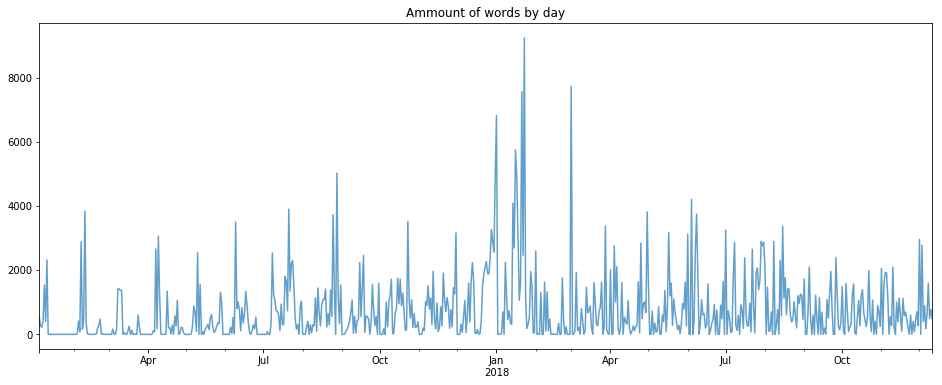

In [15]:
# Now that we have ordered data and some information about the lines (how many 
# words does each line contain) we can make a nice visualization on how was
# the flow of ammount of words per day for these chatters.

# Let's group the data by day and aggregate the sum of words (per day).
words_by_day = df.groupby(pd.Grouper(key='date', freq='1d'))['len'].apply(sum)


#plotting
fig, ax = plt.subplots(figsize=(16,6))
words_by_day.plot(ax=ax, alpha=0.7)

# axis labelling
ax.set_xlabel('')
ax.set_title('Ammount of words by day');
plt.show()


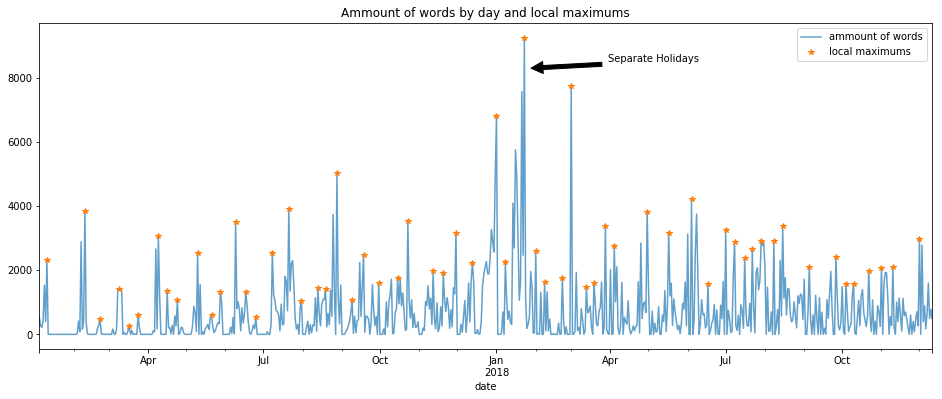

In [16]:
# It's time I reveal some information you didn't know about.
# This chat is a chat from a couple. Aparentlly they spent some
# time away from each other on January, probably on holiday.
# It also looks like they have some recurrent peaks over time.
# Let's look into that.


# finding the local maximums
ind_max = argrelmax(words_by_day.values, order=5)
maxvals = words_by_day.iloc[ind_max].to_frame()


#plotting
fig, ax = plt.subplots(figsize=(16,6))
words_by_day.plot(ax=ax, alpha=0.7)
maxvals.plot(style='*', ax=ax)

#annotations
arrow_x = pd.to_datetime('01/25/2018')
arrow_y = 8300
text_x = pd.to_datetime('03/30/2018')
text_y = 8500
ax.annotate('Separate Holidays', xy=(arrow_x, arrow_y), xytext=(text_x, text_y),
            arrowprops=dict(facecolor='black', shrink=0.05),
            )

ax.set_title('Ammount of words by day and local maximums');
plt.legend(['ammount of words', 'local maximums'])

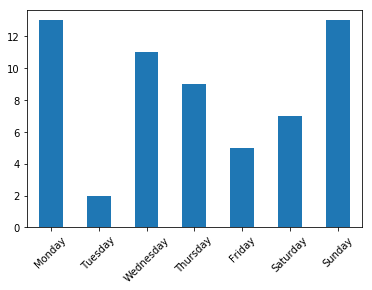

In [17]:
# Let's look into what day of the week those
# local maximums belong to.


maxvals.reset_index(inplace=True) # to set date as a column
maxvals['weekday_name'] = maxvals['date'].dt.weekday_name
ordered_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
ax = maxvals.weekday_name.value_counts()\
            .reindex(ordered_days)\
            .plot(kind='bar')
ax.tick_params(rotation=45, axis='x')

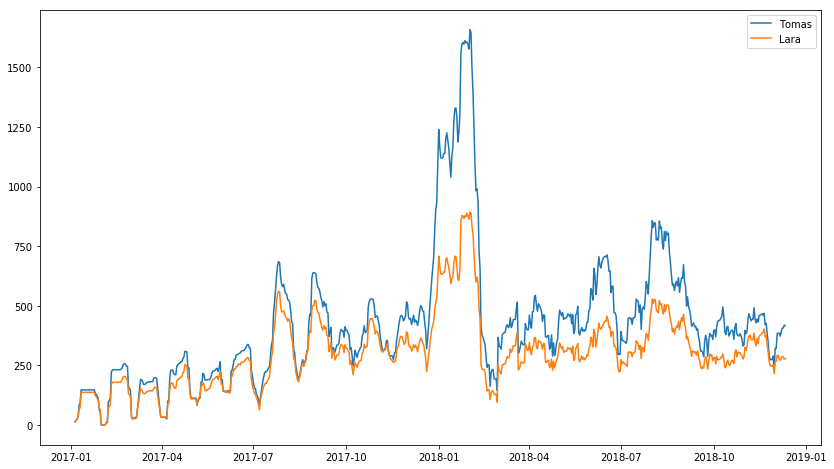

In [18]:
# Apparently they chat more on Monday's, Wednesday's, Thursday's and Sunday's.
# Maybe they work or study together during the week so they spend more time together,
# which means they don't chat that often.

# Let's now separate the data into two separate DataFrames
# Each one containing the information about each chatter.
Tomas = df[df['person'] == 'Tomas'].copy()
Lara = df[df['person'] == 'Lara'].copy()
# We can make the same calculation of words by day as we did earlier
Tomas_by_day = Tomas.groupby(pd.Grouper(key='date', freq='1d'))['len'].apply(sum)
Lara_by_day = Lara.groupby(pd.Grouper(key='date', freq='1d'))['len'].apply(sum)

# Plotting these should show us whos the more chatty.
fig, ax = plt.subplots(figsize=(14,8))
# A filter was applied to reduce the noise
n = 20  # the larger n is, the smoother curve will be
b = [1.0 / n] * n
a = 1
filtered_tomas = lfilter(b,a,Tomas_by_day.values)
filtered_lara = lfilter(b,a, Lara_by_day.values)
ax.plot(Tomas_by_day.index, filtered_tomas, label='Tomas')
ax.plot(Lara_by_day.index, filtered_lara, label='Lara')
plt.legend();

In [19]:
# Let's now try to see how many conversation they had per day.
# We can do so, by saying that if a difference equal or greater 
# than 2 hours between messagges took place, a new conversation has started.

# Boolian Series, indicating if difference to last
# row is greatter than 2 hours.
df['new_conv']= df.date.diff()>pd.Timedelta(2,'h')

def name_conversations(row):
    global counter
    if not row['new_conv']:
        row['conv_counter'] = counter
    else:
        counter += 1
        row['conv_counter'] = counter
    return row

# By creating counter variable and assigning it as global
# within our function we can now append a new value to 
# all the rows that belong to a same conversation.

counter = 0
df = df.apply(lambda x: name_conversations(x), axis=1)


df.head(10)

date person                                      line  \
1856 2017-01-05 02:02:45  Tomas                                        😍😍   
1857 2017-01-05 02:02:55  Tomas           Decile que es guitarra de autor   
1858 2017-01-05 02:03:04  Tomas               Y que el luthier se suicidó   
1859 2017-01-05 02:03:15  Tomas          Igual el puente se está abriendo   
1860 2017-01-05 02:03:28  Tomas  Las cuerdas se están separando del mango   
1861 2017-01-05 02:08:12   Lara                 Jaja si, nos dimos cuenta   
1862 2017-01-05 05:03:57  Tomas                                         😅   
1863 2017-01-05 05:04:32  Tomas             Es una linda guitarra igual 😒   
1864 2017-01-05 05:04:38  Tomas                   Cómo estuvo lo de micha   
1865 2017-01-05 09:34:53   Lara                           E linda e linda   

      len  new_conv  conv_counter  
1856    1     False             0  
1857    6     False             0  
1858    6     False             0  
1859    6     False             0  
1860    7     False             0  
1861    5     False             0  
1862    1      True             1  
1863    6     False             1  
1864    5     False             1  
1865    4      True             2

In [20]:
# Now that we have all the conversations numbered we can do some aggregation.
# Let's see how many conversations they had, and how many lines and words each 
# conversation contains.
# Let's first see how a boxplot looks like.

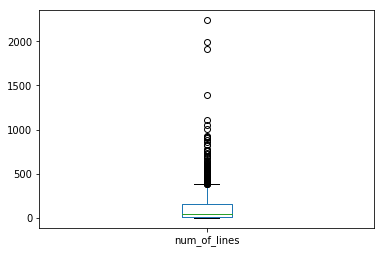

In [21]:
conv_stats = df.groupby('conv_counter').agg({'line': 'count', 'len': 'sum'}).rename(columns={'line': 'num_of_lines', 'len':'ammount_of_words'})
conv_stats.num_of_lines.plot.box()

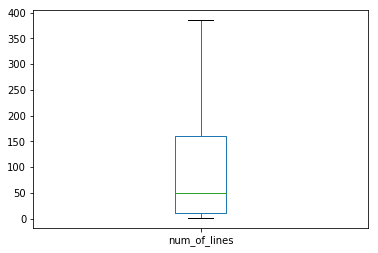

In [22]:
# how does it look like if we ommite the outliers?

conv_stats.num_of_lines.plot.box(showfliers=False)

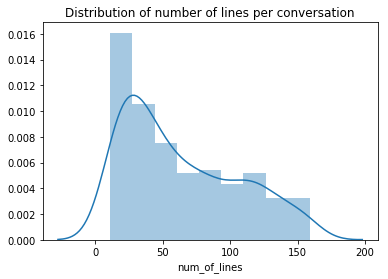

In [23]:
# Looks like we have a lot of outliers, lets look at the distribution of 
# the numer of lines per conversation in the inter-quartile-range.
first_qrt, third_qrt = np.percentile(conv_stats.num_of_lines, 25), np.percentile(conv_stats.num_of_lines, 75)
inter_quartile_convs = conv_stats[(conv_stats.num_of_lines>first_qrt) & (conv_stats.num_of_lines<third_qrt)]
ax = sns.distplot(inter_quartile_convs.num_of_lines);
ax.set_title('Distribution of number of lines per conversation');

In [24]:
# Looks like most conversations had about 45 lines as a median, however
# this distribution looks a lot skewed to the right, not normal at all.
# Lastly we could dig into how many conversation they use to have each day. 

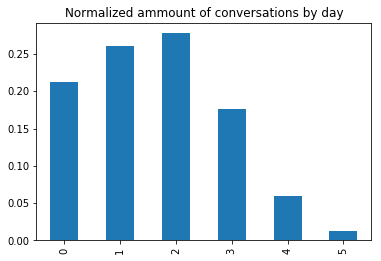

In [25]:
# We can take our conv_counter field and ask how many unique values does it have for each different day.
convs_by_day = df.groupby(pd.Grouper(key='date', freq='1d')).apply(lambda x: len(x['conv_counter'].unique()))
ax = convs_by_day.value_counts(normalize=True).reindex([0,1,2,3,4,5]).plot.bar()
ax.set_title('Normalized ammount of conversations by day');